In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from utils import train_val_test_split, create_supervised_dataset, scale_dataset, root_mean_squared_error, predict
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.patches import Rectangle

In [2]:
df = pd.read_csv('data_preparada.csv')

df['datetime'] = pd.to_datetime(
    df['datetime'],
    format = '%Y-%m-%d %H:%M:%S'
)

df = df.set_index('datetime')

df.sort_index(inplace=True)

In [3]:
INPUT_LENGTH = 24
OUTPUT_LENGTH = 1
EPOCHS = 50
BATCH_SIZE = 128
n_units = 64

results = []

for segment in df['prediction_unit_id'].unique():
    df_segment = df[(df['prediction_unit_id']==segment) & (df['is_consumption']==1)]
    train, validation, test = train_val_test_split(df_segment['target'], train_size=0.7)

    x_train, y_train = create_supervised_dataset(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_validation, y_validation = create_supervised_dataset(validation.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_test, y_test = create_supervised_dataset(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

    data_input = {
        'x_train': x_train, 'y_train': y_train,
        'x_validation': x_validation, 'y_validation': y_validation,
        'x_test': x_test, 'y_test': y_test,
    }

    data_scaled, scaler = scale_dataset(data_input)

    x_train_s, y_train_s = data_scaled['x_train_s'], data_scaled['y_train_s']
    x_validation_s, y_validation_s = data_scaled['x_validation_s'], data_scaled['y_validation_s']
    x_test_s, y_test_s = data_scaled['x_test_s'], data_scaled['y_test_s']
    
    input_shape = x_train_s.shape[1:]

    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    model = Sequential()
    model.add(LSTM(n_units, input_shape=input_shape))
    model.add(Dense(OUTPUT_LENGTH, activation='linear'))

    optimizer = RMSprop(learning_rate=5e-5)

    model.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = ['mae']
    )

    history = model.fit(
        x = x_train_s,
        y = y_train_s,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_validation_s, y_validation_s),
        verbose=0
    )

    train_loss, train_mae = model.evaluate(x=x_train_s, y=y_train_s, verbose=0)
    validation_loss, validation_mae = model.evaluate(x=x_validation_s, y=y_validation_s, verbose=0)
    test_loss, test_mae = model.evaluate(x=x_test_s, y=y_test_s, verbose=0)

    results.append([
        segment,
        train_loss,
        validation_loss,
        test_loss,
        train_mae,
        validation_mae,
        test_mae,
        history.history['loss'],
        history.history['val_loss'],
        history.history['mae'],
        history.history['val_mae']
    ])    

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\david\OneDrive\Escritorio\ucc\enefit\

KeyboardInterrupt: 

In [5]:
results_base_consumption = pd.DataFrame(results,
                                        columns=[
                                            'segment', 'train_loss', 'validation_loss', 'test_loss',
                                            'train_mae', 'validation_mae', 'test_mae', 'loss',
                                            'val_loss', 'mae', 'val_mae'])

results_base_consumption.to_csv("results_base_lstm_univ_unist_consumption.csv", index=False)

In [4]:
results_base_consumption = pd.read_csv("results_base_lstm_univ_unist_consumption.csv")
results_base_consumption['mae'] = results_base_consumption['mae'].apply(lambda x: list(map(float, x[1:-1].split(','))))
results_base_consumption['val_mae'] = results_base_consumption['val_mae'].apply(lambda x: list(map(float, x[1:-1].split(','))))

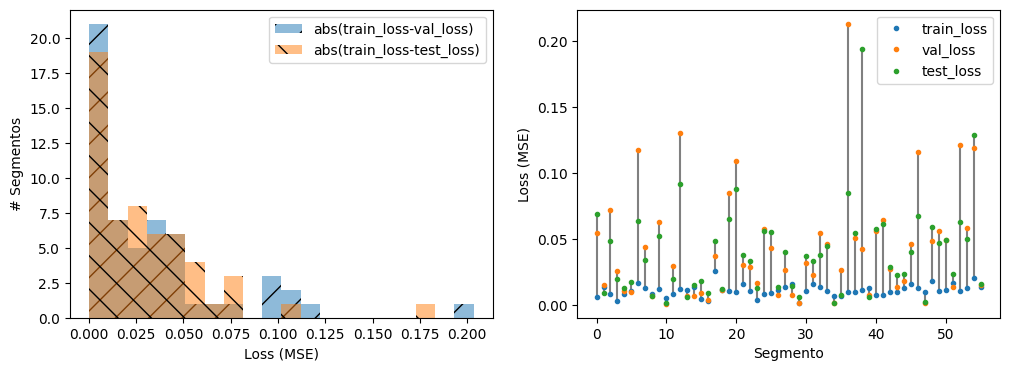

In [72]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
train_val_loss_abs = np.abs(results_base_consumption['train_loss']-results_base_consumption['validation_loss'])
train_test_loss_abs = np.abs(results_base_consumption['train_loss']-results_base_consumption['test_loss'])
full_range = (min(train_val_loss_abs.min(), train_test_loss_abs.min()), max(train_val_loss_abs.max(), train_test_loss_abs.max()))
plt.hist(train_val_loss_abs, alpha=0.5, hatch='/', label='abs(train_loss-val_loss)', range=full_range, bins=20)
plt.hist(train_test_loss_abs, alpha=0.5, hatch='\\', label='abs(train_loss-test_loss)', range=full_range, bins=20)
plt.xlabel('Loss (MSE)')
plt.ylabel('# Segmentos')
plt.legend()

plt.subplot(1,2,2)

for i in range(len(results_base_consumption)):
    x_ini = i
    y_ini = min(results_base_consumption.loc[i,['train_loss','validation_loss','test_loss']])
    y_end = max(results_base_consumption.loc[i,['train_loss','validation_loss','test_loss']])
    plt.vlines(x=x_ini, ymin=y_ini, ymax=y_end, color='gray', linestyle='-')

plt.plot(results_base_consumption['train_loss'], '.', label='train_loss')
plt.plot(results_base_consumption['validation_loss'], '.', label='val_loss')
plt.plot(results_base_consumption['test_loss'], '.', label='test_loss')
plt.ylabel("Loss (MSE)")
plt.xlabel('Segmento')
plt.legend()

plt.show()

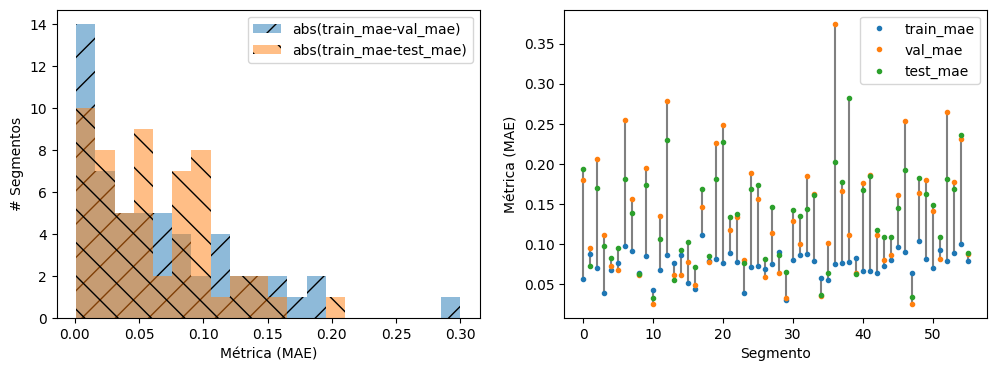

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
train_val_mae_abs = np.abs(results_base_consumption['train_mae']-results_base_consumption['validation_mae'])
train_test_mae_abs = np.abs(results_base_consumption['train_mae']-results_base_consumption['test_mae'])
full_range = (min(train_val_mae_abs.min(), train_test_mae_abs.min()), max(train_val_mae_abs.max(), train_test_mae_abs.max()))
plt.hist(train_val_mae_abs, alpha=0.5, hatch='/', label='abs(train_mae-val_mae)', range=full_range, bins=20)
plt.hist(train_test_mae_abs, alpha=0.5, hatch='\\', label='abs(train_mae-test_mae)', range=full_range, bins=20)
plt.xlabel('Métrica (MAE)')
plt.ylabel('# Segmentos')
plt.legend()

plt.subplot(1,2,2)

for i in range(len(results_base_consumption)):
    x_ini = i
    y_ini = min(results_base_consumption.loc[i,['train_mae','validation_mae','test_mae']])
    y_end = max(results_base_consumption.loc[i,['train_mae','validation_mae','test_mae']])
    plt.vlines(x=x_ini, ymin=y_ini, ymax=y_end, color='gray', linestyle='-')

plt.plot(results_base_consumption['train_mae'], '.', label='train_mae')
plt.plot(results_base_consumption['validation_mae'], '.', label='val_mae')
plt.plot(results_base_consumption['test_mae'], '.', label='test_mae')
plt.ylabel("Métrica (MAE)")
plt.xlabel('Segmento')
plt.legend()

plt.show()

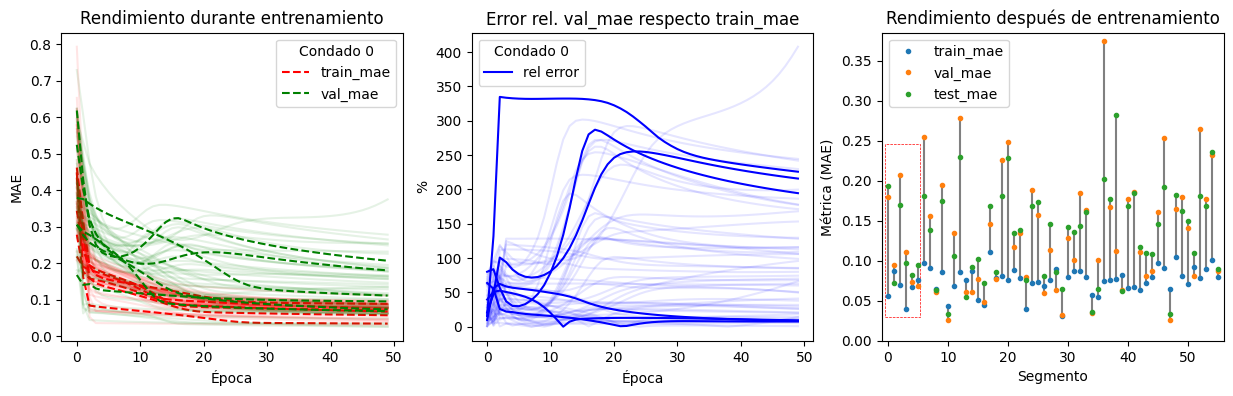

In [85]:

from matplotlib.lines import Line2D

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)


for idx, serie in enumerate(results_base_consumption['mae']):
    if idx<=5:
        plt.plot(serie, c='red', linestyle='--')
    else:
        plt.plot(serie, c='red', alpha=0.1)

for idx, serie in enumerate(results_base_consumption['val_mae']):
    if idx<=5:
        plt.plot(serie, 'green', linestyle='--')
    else:
        plt.plot(serie, c='green', alpha=0.1)

custom_lines = [Line2D([0], [0], color='red', linestyle='--'),
                Line2D([0], [0], color='green', linestyle='--')]
plt.legend(custom_lines, ['train_mae', 'val_mae']).set_title('Condado 0')

plt.title('Rendimiento durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')

plt.subplot(1,3,2)

relative_error_train_val_mae = results_base_consumption[['mae', 'val_mae']].apply(
    lambda x: np.abs(np.array(x['val_mae'])-np.array(x['mae']))/np.array(x['mae'])*100,
    axis=1
)

for idx, serie in enumerate(relative_error_train_val_mae):
    if idx<=5:
        plt.plot(serie, c='blue')
    else:
        plt.plot(serie, c='blue', alpha=0.1)

custom_lines = [Line2D([0], [0], color='blue', linestyle='-')]
plt.legend(custom_lines, ['rel error']).set_title('Condado 0')

plt.title('Error rel. val_mae respecto train_mae')
plt.xlabel('Época')
plt.ylabel('%')

plt.subplot(1,3,3)

for i in range(len(results_base_consumption)):
    x_ini = i
    y_ini = min(results_base_consumption.loc[i,['train_mae','validation_mae','test_mae']])
    y_end = max(results_base_consumption.loc[i,['train_mae','validation_mae','test_mae']])
    plt.vlines(x=x_ini, ymin=y_ini, ymax=y_end, color='gray', linestyle='-')

plt.plot(results_base_consumption['train_mae'], '.', label='train_mae')
plt.plot(results_base_consumption['validation_mae'], '.', label='val_mae')
plt.plot(results_base_consumption['test_mae'], '.', label='test_mae')
plt.ylabel("Métrica (MAE)")
plt.xlabel('Segmento')
plt.title('Rendimiento después de entrenamiento')
plt.legend()

rect = Rectangle(
    (-0.5, min(results_base_consumption.loc[:5,['train_mae', 'validation_mae', 'test_mae']].min())-0.01),
    5.8,
    max(results_base_consumption.loc[:5,['train_mae', 'validation_mae', 'test_mae']].max())+0.01, linewidth=0.5, edgecolor='red', fill=False, linestyle='--')

# Añadir el rectángulo al gráfico
plt.gca().add_patch(rect)

# Configurar límites del gráfico
plt.xlim(-1, 56)
plt.ylim(0, max(results_base_consumption[['train_mae', 'validation_mae', 'test_mae']].max())+0.01)


plt.show()

In [8]:
results_base_consumption[['segment','test_mae']].sort_values('test_mae')

,segment,test_mae
10,10,0.032982
47,52,0.033392
34,36,0.036337
13,13,0.055088
39,42,0.062700
8,8,0.062936
35,37,0.064144
29,31,0.064764
16,16,0.071649
1,1,0.072317


c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


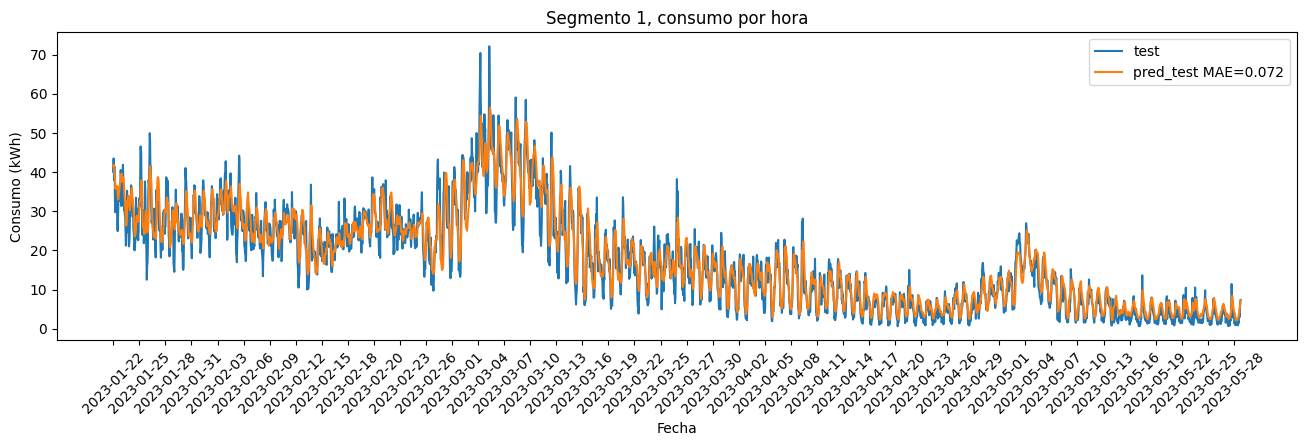

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


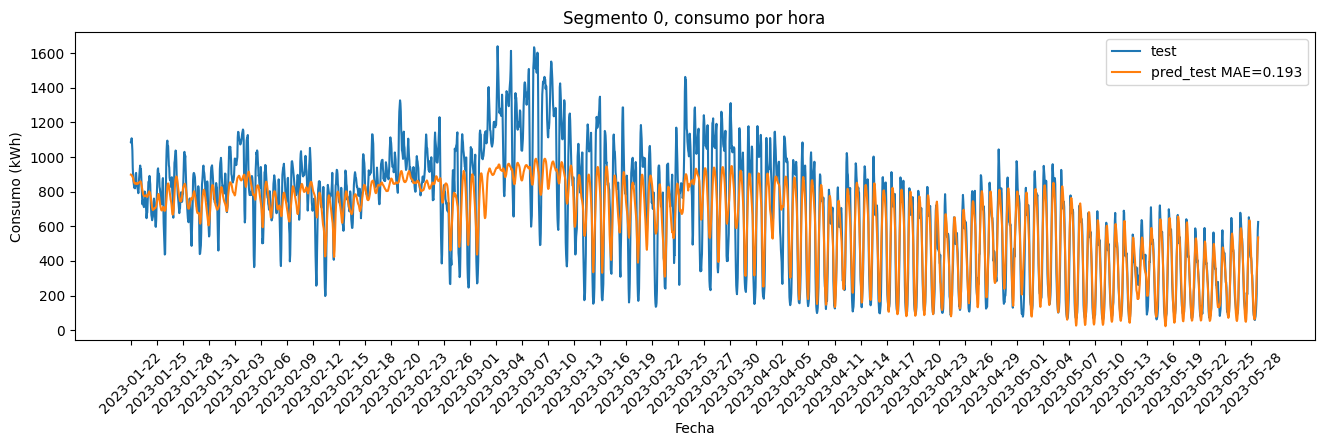

In [7]:
some_segments = [1, 0]

INPUT_LENGTH = 24
OUTPUT_LENGTH = 1
EPOCHS = 50
BATCH_SIZE = 128
n_units = 64

for segment in some_segments:
    df_segment = df[(df['prediction_unit_id']==segment) & (df['is_consumption']==1)]
    train, validation, test = train_val_test_split(df_segment['target'], train_size=0.7)

    x_train, y_train = create_supervised_dataset(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_validation, y_validation = create_supervised_dataset(validation.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_test, y_test = create_supervised_dataset(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

    data_input = {
        'x_train': x_train, 'y_train': y_train,
        'x_validation': x_validation, 'y_validation': y_validation,
        'x_test': x_test, 'y_test': y_test,
    }

    data_scaled, scaler = scale_dataset(data_input)

    x_train_s, y_train_s = data_scaled['x_train_s'], data_scaled['y_train_s']
    x_validation_s, y_validation_s = data_scaled['x_validation_s'], data_scaled['y_validation_s']
    x_test_s, y_test_s = data_scaled['x_test_s'], data_scaled['y_test_s']
    
    input_shape = x_train_s.shape[1:]

    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    model = Sequential()
    model.add(LSTM(n_units, input_shape=input_shape))
    model.add(Dense(OUTPUT_LENGTH, activation='linear'))

    optimizer = RMSprop(learning_rate=5e-5)

    model.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = ['mae']
    )

    history = model.fit(
        x = x_train_s,
        y = y_train_s,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_validation_s, y_validation_s),
        verbose=0
    )

    y_test_pred = predict(x_test_s, model, scaler)
    n = 70
    plt.figure(figsize=(16,4))
    plt.plot(y_test.flatten(), label='test')
    mae = results_base_consumption.loc[results_base_consumption[results_base_consumption['segment']==segment].index, 'test_mae']
    plt.plot(y_test_pred, label=f'pred_test MAE={mae.round(3).values[0]}')
    plt.legend()
    plt.ylabel('Consumo (kWh)')
    plt.xlabel('Fecha')
    plt.xticks(range(0, len(test), n), list(test.index.date)[::n], rotation=45)
    plt.title(f"Segmento {segment}, consumo por hora")
    plt.show() 